In [130]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [131]:
bag = rosbag.Bag('/home/uware/rosbags/static/rotation/25h9/s_yaw_25h9_5m_720_30.bag')

# create variables
target = 'yaw'
true_value = 'true_yaw'

# input values in degrees. the order matters, it will be used for binning 
input_vals = [0,15,30,45,60]

In [132]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t

    # conversion to euler
    rotation_quat = msg.transforms[0].transform.rotation
    pitch, yaw, roll = tf.transformations.euler_from_quaternion([rotation_quat.x,rotation_quat.y,rotation_quat.z,rotation_quat.w], axes='rxyz')

    # all rotations
    # rotation_euler = (np.degrees(pitch), np.degrees(yaw), np.degrees(roll))

    # create row
    row={'time': time.to_sec(), target: np.degrees(yaw)}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [133]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,yaw
0,0.000000,19.184147
1,0.314762,9.728676
2,0.646649,2.299237
3,1.004957,4.661084
4,1.367453,5.171209
...,...,...
634,73.828207,56.307009
635,73.936139,56.278071
636,74.036772,56.514312
637,74.148811,57.617451


<AxesSubplot:xlabel='relative_time'>

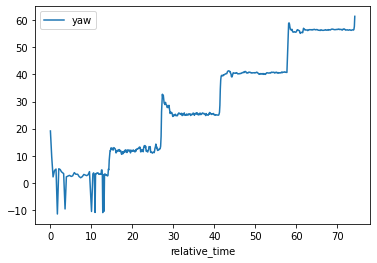

In [134]:
# initial graph
df.plot(x='relative_time', y=target)

In [135]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 1)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [136]:
# the amount of data points we are left with
len(x[peaks])

148

In [137]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='yaw'>

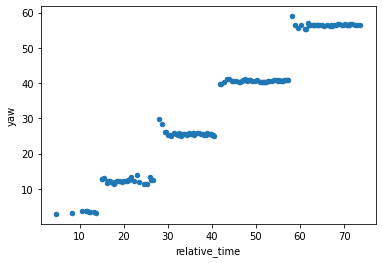

In [138]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [139]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.qcut(df_filtered_by_targets[target], len(input_vals), labels=input_vals, duplicates='drop')
df_filtered_by_targets

,relative_time,yaw,true_yaw
12,4.639035,2.862260,0
21,8.152483,3.202521,0
27,10.540863,3.789230,0
35,11.518470,3.785727,0
37,11.721269,3.611911,0
...,...,...,...
611,71.415084,56.635778,60
614,71.725652,56.646536,60
621,72.483320,56.372932,60
626,73.012953,56.398748,60


In [140]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [141]:
# remove huge errors because theyre actually wrongly binned
df_filtered_by_targets = df_filtered_by_targets.drop(df_filtered_by_targets[df_filtered_by_targets['error'].abs()>9].index)

In [142]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [143]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.tail(2)

,relative_time,yaw,true_yaw,error
52,13.314165,3.351904,0,-3.351904
55,13.623836,3.064722,0,-3.064722
146,23.048728,13.809426,15,1.190574
174,25.938735,13.357080,15,1.642920
298,38.826345,25.973956,30,4.026044
300,39.047411,25.675377,30,4.324623
472,57.054585,40.905667,45,4.094333
475,57.376479,40.776410,45,4.223590
626,73.012953,56.398748,60,3.601252
633,73.719551,56.354971,60,3.645029


In [144]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_yaw,,,,,,,,
0,9.0,-3.377996,0.313846,-3.789230,-3.611911,-3.351904,-3.202521,-2.862260
15,7.0,1.857975,0.370653,1.190574,1.675308,1.939635,2.161750,2.201502
30,14.0,3.721774,1.181905,0.308876,4.013241,4.193262,4.232199,4.342517
45,23.0,4.225627,0.169136,3.714726,4.199597,4.223590,4.365340,4.425781
60,30.0,3.430385,0.460456,1.084555,3.434699,3.546562,3.596762,3.675647


In [145]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

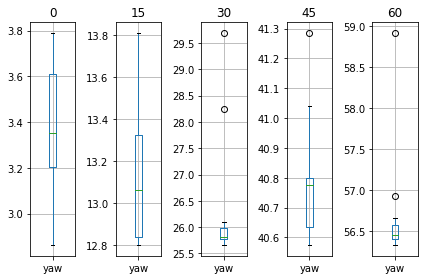

In [146]:
box_plotter(target)

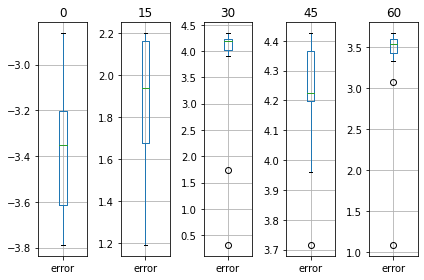

In [147]:
box_plotter('error')

In [148]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df_filtered_by_targets)

,relative_time,yaw,true_yaw,error
12,4.639035,2.862260,0,-2.862260
21,8.152483,3.202521,0,-3.202521
27,10.540863,3.789230,0,-3.789230
35,11.518470,3.785727,0,-3.785727
37,11.721269,3.611911,0,-3.611911
40,12.034135,3.334633,0,-3.334633
42,12.249389,3.399056,0,-3.399056
52,13.314165,3.351904,0,-3.351904
55,13.623836,3.064722,0,-3.064722
68,14.971570,12.858346,15,2.141654
